<a href="https://colab.research.google.com/github/MhmdSafa7/Chest_disease_DL/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Colab Notebooks"


chest_xray  main.ipynb


In [4]:
!ls "/content/drive/MyDrive/Colab Notebooks/chest_xray/train"

NORMAL	PNEUMONIA


In [5]:


train_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test'
base_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print("Classes:", os.listdir(train_dir))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: ['PNEUMONIA', 'NORMAL']


In [6]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')




In [7]:
for split in ['train', 'val', 'test']:
    path = os.path.join(base_dir, split)
    classes = os.listdir(path)
    print(f"\n📂 {split.upper()} set:")

    for c in classes:
        class_path = os.path.join(path, c)
        if not os.path.isdir(class_path):   # 👈 skip files like .DS_Store
            continue
        count = len(os.listdir(class_path))
        print(f"  {c:10s}: {count} images")





📂 TRAIN set:
  PNEUMONIA : 3875 images
  NORMAL    : 1341 images

📂 VAL set:
  PNEUMONIA : 8 images
  NORMAL    : 8 images

📂 TEST set:
  PNEUMONIA : 390 images
  NORMAL    : 234 images


In [8]:
!find /content/drive/MyDrive/Colab\ Notebooks/chest_xray -name ".DS_Store" -delete



🩻 Sample images for PNEUMONIA:


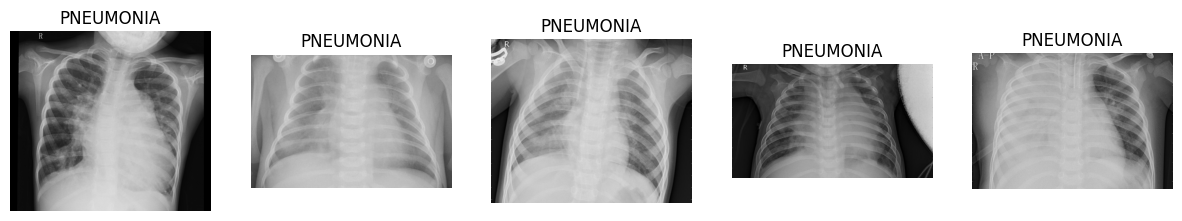


🩻 Sample images for NORMAL:


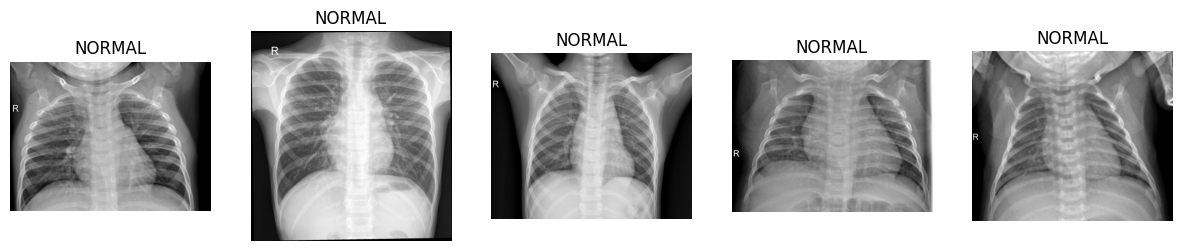

In [9]:
def show_random_images(folder, n=5):
    plt.figure(figsize=(15,5))
    images = os.listdir(folder)
    for i in range(n):
        img_path = os.path.join(folder, random.choice(images))
        img = plt.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(folder))
        plt.axis('off')
    plt.show()

# Show examples from each class
for category in os.listdir(train_dir):
    print(f"\n🩻 Sample images for {category}:")
    show_random_images(os.path.join(train_dir, category))


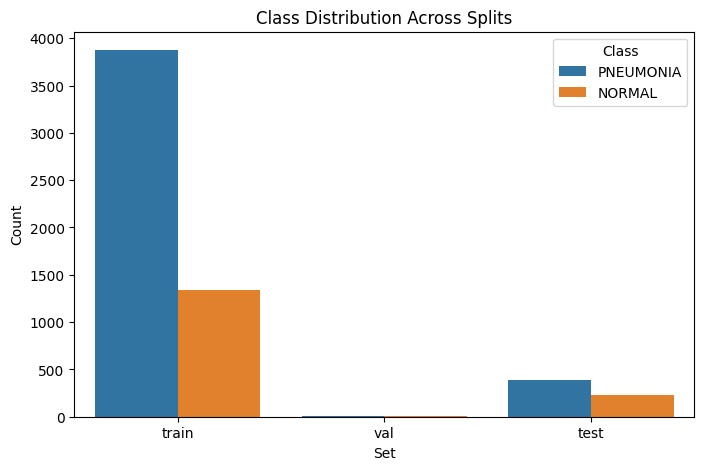

In [10]:
counts = []
for split in ['train', 'val', 'test']:
    for c in os.listdir(os.path.join(base_dir, split)):
        count = len(os.listdir(os.path.join(base_dir, split, c)))
        counts.append({'Set': split, 'Class': c, 'Count': count})

df = pd.DataFrame(counts)
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Set', y='Count', hue='Class')
plt.title('Class Distribution Across Splits')
plt.show()

In [11]:


# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values (0–255 → 0–1)
    rotation_range=20,            # Random rotation
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    shear_range=0.2,              # Shear transform
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip horizontally
    fill_mode='nearest'           # Fill empty pixels
)

# Validation and test data (only normalization)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Define paths
train_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/chest_xray/test'


In [12]:
IMG_SIZE = 224  # or 150

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),  # resize images
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


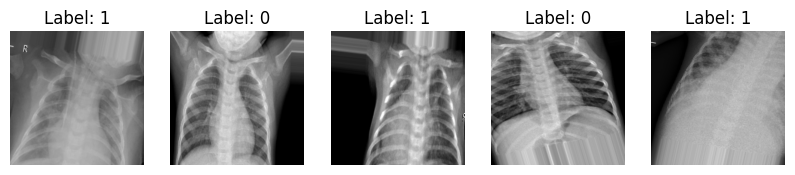

In [13]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.show()

In [14]:
IMG_SIZE = 224  # must match your generator

model = models.Sequential([
    # 1️⃣ Convolution + Pooling Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    # 2️⃣ Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 3️⃣ Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # 4️⃣ Flatten + Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # helps prevent overfitting
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1246s 8s/step - accuracy: 0.7402 - loss: 0.7002 - val_accuracy: 0.5625 - val_loss: 0.6567
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 723ms/step - accuracy: 0.8469 - loss: 0.3423 - val_accuracy: 0.6875 - val_loss: 0.6087
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.8690 - loss: 0.2964 - val_accuracy: 0.8125 - val_loss: 0.5546
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 719ms/step - accuracy: 0.8814 - loss: 0.2869 - val_accuracy: 0.7500 - val_loss: 0.4706
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.8811 - loss: 0.2724 - val_accuracy: 0.7500 - val_loss: 0.5291
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 717ms/step - accuracy: 0.8918 - loss: 0.2555 - val_accuracy: 0.6875 - val_loss: 0.6840
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 118s 722ms/step - accuracy: 0.8926 - loss: 0.2488 - val_accuracy: 0.7500 - val_loss: 0.5244
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 718ms/step - accuracy: 0.9119 - l